# orienté objet (copie avec modif de raphael)

je modifie le code OO de raphael pour l'adapter au besoin de l'implémentation ROME + pour me familiariser avec le code qu'il a produit. Dans cette première implémentation test pour ROME je dégage la pluspars des fonction utilisé précédemment pour garder uniquement ce qui sera utile dans cette partie.

J'ai enlever le truc de batch et la mise sur GPU parce que j'y comprend R.

In [1]:
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
import torch
from functools import partial
import torch.nn.functional as F

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
#inputs = les prompts sur lesquels on va calculer k* et v*
#subject le sujet pour qui il faut determiner k*,v*
class Instance_for_ROME :
    def __init__(self, subject, inputs= None, l_star = 18, model_name = 'gpt2-xl', nb_prompt=50):
        self.model_name = model_name
        self.subject = subject
        self._l_star = l_star

        self.model = GPT2LMHeadModel.from_pretrained(model_name).to(device)
        self.tokenizer = GPT2TokenizerFast.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        if inputs == None:
            self.generate_prompts(50)
        else:
            self.prompts = inputs

        self._subject_mask = self.compute_subject_mask()
        self._last_subject_indices = (self._subject_mask * torch.arange(1, self._subject_mask.shape[1] + 1, device=self._subject_mask.device)).argmax(dim=1)

        self._ks = None
        self._k_star = None
        self._hooks = []
        self._logits = None
        self.output = None

    def __str__(self):
        return f'Instance of {self.model.config.architectures[0]} model'
    
    def tokenize(self, batch, offsetsMapping=False):
        inputs = self.tokenizer(batch, return_tensors='pt', padding=True, return_offsets_mapping=offsetsMapping)
        return {k: v.to(device) for k, v in inputs.items()}  # Ensure inputs are moved to device
    
    def compute_subject_mask(self, prompts = None, subject = None):
        res = []

        if prompts == None:
            prompts = self.prompts
        if subject == None:
            subject = self.subject

        input = self.tokenize(prompts, offsetsMapping=True)
        mask = []
        for j, prompt in enumerate(prompts):
            map = torch.zeros_like(input['input_ids'][j], dtype=torch.int)
            for i, t in enumerate(input['offset_mapping'][j]):
                if (prompts[j].find(subject)-1 <= t[0]) and (t[1] <= prompts[j].find(subject)+len(subject)) and (prompts[j].find(subject) != -1):
                    map[i] = 1
            mask.append(map)
        subject_mask = torch.stack(mask)
        subject_mask = torch.logical_and(subject_mask, input['attention_mask']).int()
        return subject_mask
    
    def get_ks_hook(self, last_subject_indices=None):
        if last_subject_indices is None:
            last_subject_indices = self._last_subject_indices
        
        def hook(module, input, output):
            if isinstance(input[0], torch.Tensor) and isinstance(input, tuple):
                hidden = input[0]
                res = hidden[torch.arange(len(last_subject_indices), device=hidden.device), last_subject_indices]
                self._ks = res
            else:
                raise TypeError("Expected input[0] to be a torch.Tensor, but got {}".format(type(input[0])))
            pass
        
        return hook
    
    def accroche(self, l_star=None):
        if l_star is None:
            l_star = self._l_star
        hook = self.get_ks_hook()
        handle = self.model.transformer.h[l_star].mlp.register_forward_hook(hook)
        self._hooks.append(handle)
        pass
    
    def enleve(self):
        for handle in self._hooks:
            handle.remove()
        self._hooks = []
        pass
    
    def run(self, conserve_logits=False, conserve_output=False):
        input = self.tokenize(self.prompts)
        with torch.no_grad():
            output = self.model(**input, labels=input['input_ids']) 
        if self._ks is not None:
            self._k_star = torch.mean(self._ks, dim=0)
        if conserve_logits:
            self._logits = output.logits
        if conserve_output:
            self._output = output
        pass

    def generate_prompts(self, nb_prompt, min_len=2, max_len=11):
        vocab_size = self.tokenizer.vocab_size
        nb_token = torch.randint(min_len, max_len, (nb_prompt,), device=device)
        max_tokens = nb_token.max()
        tokens = torch.randint(0, vocab_size, (nb_prompt, max_tokens), device=device)
        padded_tokens = F.pad(tokens, (0, max_tokens - nb_token.max().item()), value=vocab_size)
        decoded_sequences = [self.tokenizer.decode(seq[:nb_token[i].item()]) for i, seq in enumerate(padded_tokens)]
        res = [x + ' ' + self.subject for x in decoded_sequences]
        self.__init__(self.subject, res, self._l_star, self.model_name)
        pass

    def get_k_star(self, l_star=None):
        self.accroche(l_star)
        self.run()
        self.enleve()
        return self._k_star


In [3]:
test = Instance_for_ROME('Eiffel Tower')

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [4]:
test.generate_prompts(50)
test.get_k_star()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


tensor([-0.7923, -0.3777, -0.7283,  ..., -0.2987,  0.1235,  0.0989],
       device='cuda:0')

## Compute v*

Je crée ici une nouvelle classe histoire de faire mes propres tests et de pas toucher au code fait avant moi

Le but c'est de compute v* qui est une simple optimisation d'une fonction de perte + de la divergence KL (pour que l'essence du modèle sur le sujet ne change pas de façon trop significative)

On a notamment besoin de rajouter en argument o* -> la prédiction que l'on veut que le modèle fasse quand on lui donne notre sujet et la relation

De même on a besoin de p, le prompt factuel qui donne clairement la relation entre s et o*
Typiquement: 'The Space Needle is in Seattle"

In [3]:
from torch.optim import Adam

In [5]:
class ValueEditor:
    def __init__(self, instance, o_star):
        self.instance = instance
        self.o_star = o_star
        self._v_star = torch.nn.Parameter(torch.randn([1, 1600], device=device))  # Moved tensor to device

        self._hook_handle = None

    def mlp_output_hook(self, module, input, output):  # Simple hook pour insérer v* à la bonne couche
        return self._v_star.unsqueeze(0).expand_as(output).to(output.device)  # Ensure same device

    def accroche(self):
        l_star = self.instance._l_star
        handle = self.instance.model.transformer.h[l_star].mlp.c_proj.register_forward_hook(self.mlp_output_hook)
        self._hook_handle = handle

    def enleve(self):
        if self._hook_handle is not None:
            self._hook_handle.remove()

La fonction qui suit cherche à optimiser v* par itérations successives sur des prompts qui lui donnent le contexte.

[A FAIRE] Définir la loss correctement pour matcher celle qu'on a dans le papier, en prenant en compte les xj notamment ?

In [34]:
def optimize_v_star(editor, factual_prompts, o_star, n_iter=300, lr=0.1, early_stop_threshold=0.01, lambda_kl=30):
    """
    Optimise v* pour forcer le modèle à prédire o* juste après le prompt,
    tout en contrôlant l'essence du sujet avec la KL divergence.
    """
    instance = editor.instance
    tokenizer = instance.tokenizer
    model = instance.model

    editor.accroche()
    optimizer = torch.optim.Adam([editor._v_star], lr=lr)
    loss_fn = torch.nn.CrossEntropyLoss()

    input_prompts = [template.format(subject=instance.subject) for template in factual_prompts]
    tokenized = tokenizer(input_prompts, return_tensors="pt", padding=True)

    input_ids = tokenized.input_ids.to(device)  # Move to device
    attention_mask = tokenized.attention_mask.to(device)  # Move to device

    seq_len = input_ids.shape[1]

    # Token ID cible (premier token de o_star)
    target_token_id = tokenizer.encode(o_star, add_special_tokens=False)[0]

    # Stocker les logits originaux pour le KL divergence
    with torch.no_grad():
        outputs_original = model(input_ids=input_ids, attention_mask=attention_mask)
        logits_original = outputs_original.logits

    # On garde une trace de la loss pour produire des graphiques
    CE_list = []
    KL_list = []
    loss_list = []

    for i in range(n_iter):
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits_modified = outputs.logits

        # === 1. CrossEntropy Loss ===
        target_logits = logits_modified[:, seq_len-1, :]

        targets = torch.full((target_logits.size(0),), target_token_id, dtype=torch.long, device=target_logits.device)
        ce_loss = loss_fn(target_logits, targets)

        CE_list.append(ce_loss.cpu().detach().numpy())

        # === 2. KL Divergence Loss ===
        logits_modified_flat = logits_modified.view(-1, logits_modified.size(-1))
        logits_original_flat = logits_original.view(-1, logits_original.size(-1))

        probs_modified = torch.nn.functional.softmax(logits_modified_flat, dim=-1)
        probs_original = torch.nn.functional.softmax(logits_original_flat, dim=-1)

        kl_loss = torch.nn.functional.kl_div(probs_modified.log(), probs_original, reduction="batchmean")

        KL_list.append(kl_loss.cpu().detach().numpy())

        # === 3. Loss totale ===
        loss = ce_loss + lambda_kl * kl_loss

        loss_list.append(loss.cpu().detach().numpy())

        loss.backward()
        optimizer.step()

        if i % 10 == 0 or loss.item() < early_stop_threshold:
            print(f"[{i}] Total Loss = {loss.item():.6f} | CE = {ce_loss.item():.6f} | KL = {kl_loss.item():.6f}")

        if loss.item() < early_stop_threshold:
            print(f"\nEarly stopping at iteration {i} with loss {loss.item():.6f}")
            break

    editor.enleve()
    return editor._v_star.detach(), CE_list, KL_list, loss_list

Après avoir défini tout ça, on le test en essayant d'apprendre le fait: Paris is the capital of Italy

In [7]:
subject = 'Paris'
instance = Instance_for_ROME(subject)
instance.get_k_star()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


tensor([-0.2230, -0.1643,  0.1199,  ..., -0.7447, -0.2100, -0.4088],
       device='cuda:0')

In [35]:
subject = 'Paris'
o_star = 'Italy'
factual_prompts = [
    '{subject} is the capital of',
    'In which country is {subject} located?',
    'Where is {subject}?',
    "The country that governs {subject} is",
    "The location of {subject} is in",
    "{subject} is situated in the country of",
    "Which nation does {subject} belong to?",
    "In which country is {subject} found?",
    "{subject} is part of the country called",
    "The city of {subject} is a part of",
    "The famous city {subject} is located in",
    "You can find {subject} in the country of",
    "The administrative country for {subject} is"
]

editor = ValueEditor(instance, o_star)

v_star, CE_list, KL_list, loss_list = optimize_v_star(editor, factual_prompts, o_star)

print(v_star)


[0] Total Loss = 9.967159 | CE = 9.967159 | KL = 0.000000
[10] Total Loss = 8.303061 | CE = 7.655899 | KL = 0.021572
[20] Total Loss = 7.292048 | CE = 6.105126 | KL = 0.039564
[30] Total Loss = 6.260905 | CE = 4.347546 | KL = 0.063779
[40] Total Loss = 5.613227 | CE = 3.220129 | KL = 0.079770
[50] Total Loss = 5.281080 | CE = 2.836947 | KL = 0.081471
[60] Total Loss = 5.201946 | CE = 3.002823 | KL = 0.073304
[70] Total Loss = 5.033255 | CE = 2.754513 | KL = 0.075958
[80] Total Loss = 4.950420 | CE = 2.709869 | KL = 0.074685
[90] Total Loss = 4.887903 | CE = 2.574508 | KL = 0.077113
[100] Total Loss = 4.837952 | CE = 2.579188 | KL = 0.075292
[110] Total Loss = 4.802954 | CE = 2.588652 | KL = 0.073810
[120] Total Loss = 4.790927 | CE = 2.475065 | KL = 0.077195
[130] Total Loss = 4.755118 | CE = 2.541702 | KL = 0.073781
[140] Total Loss = 4.732186 | CE = 2.512642 | KL = 0.073985
[150] Total Loss = 4.758039 | CE = 2.392614 | KL = 0.078847
[160] Total Loss = 4.746684 | CE = 2.612745 | KL = 

## Insertion (k,v) -> Update de W_proj

Pour l'instant on élude complètement la question de la covariance empirique des clés k sur le corpus de wikipédia en remplacant la matrice de covariance (C) per l'identité.
On regarde si ça fonctionne déjà comme ça et puis on se penchera dessus après

In [24]:
def apply_rank_one_update(instance, v_star, C_inv=None):
    l_star = instance._l_star
    k_star = instance._k_star.to(device)  # Assurer que k_star est sur GPU
    W_proj = instance.model.transformer.h[l_star].mlp.c_proj.weight  # Déjà sur le modèle, donc sur device

    W_fc = instance.model.transformer.h[l_star].mlp.c_fc.weight  # Pareil
    k_star_projected = torch.nn.functional.linear(k_star, W_fc.t())

    if C_inv is None:
        C_inv = torch.eye(k_star_projected.size(0), device=k_star_projected.device)  # sur device correct

    # 1. Calculer Lambda
    numerator = v_star - W_proj.t() @ k_star_projected
    denominator = (C_inv @ k_star_projected).dot(k_star_projected)
    Lambda = numerator / denominator

    # 2. Calculer delta_W
    delta_W = Lambda.view(-1, 1) @ (C_inv @ k_star_projected).view(1, -1)

    # 3. Appliquer la mise à jour
    with torch.no_grad():
        W_proj.data += delta_W.t()

    print("Mise à jour appliquée avec succès sur W_proj.")


In [25]:
apply_rank_one_update(instance, v_star)

Mise à jour appliquée avec succès sur W_proj.


In [26]:
def test_new_fact(instance, subject, prompt_template, top_k=5):
    tokenizer = instance.tokenizer
    model = instance.model
    model.eval()

    prompt = prompt_template.format(subject=subject)
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs.input_ids.to(device)  # Move to device
    attention_mask = inputs.attention_mask.to(device)  # Move to device

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        next_token_logits = logits[0, -1, :]
        probs = torch.nn.functional.softmax(next_token_logits, dim=-1)
        top_probs, top_indices = probs.topk(top_k)
        top_tokens = [tokenizer.decode([idx]) for idx in top_indices]

    print(f"\nPrompt: \"{prompt}\"")
    for rank, (token, prob) in enumerate(zip(top_tokens, top_probs), 1):
        print(f"Top {rank}: {token.strip()} ({prob.item():.4f})")

# Tester sur quelques prompts :
test_new_fact(instance, subject, "{subject} is the capital of")
test_new_fact(instance, subject, "The administrative country for {subject} is")



Prompt: "Paris is the capital of"
Top 1: France (0.6256)
Top 2: the (0.1523)
Top 3: a (0.0214)
Top 4: Europe (0.0145)
Top 5: French (0.0142)

Prompt: "The administrative country for Paris is"
Top 1: the (0.1769)
Top 2: France (0.0493)
Top 3: a (0.0462)
Top 4: located (0.0257)
Top 5: not (0.0211)


## Pourquoi ça ne fonctionne pas

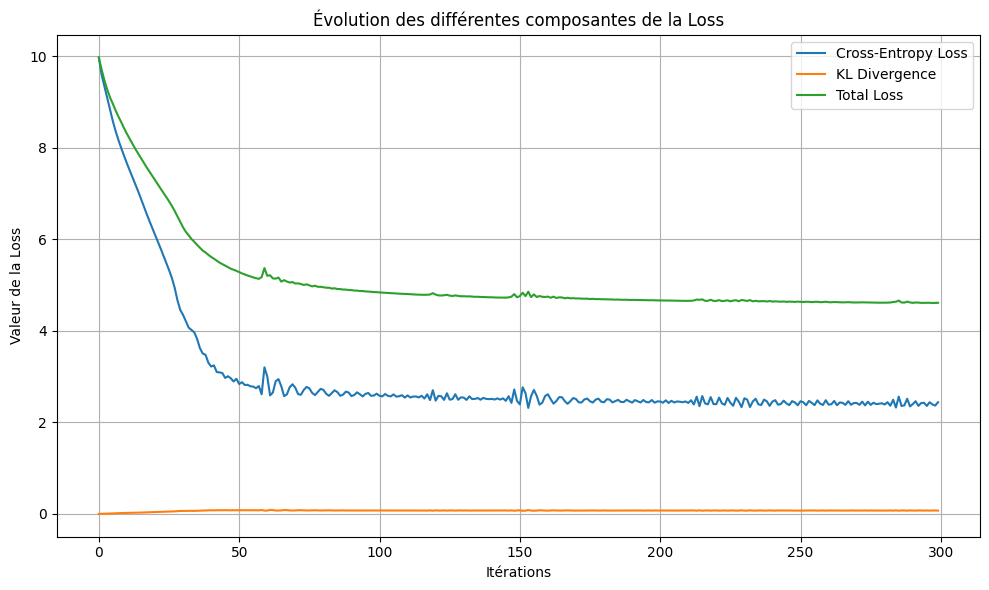

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Taille plus grande pour plus de lisibilité

plt.plot(CE_list, label="Cross-Entropy Loss")
plt.plot(KL_list, label="KL Divergence")
plt.plot(loss_list, label="Total Loss")

plt.title("Évolution des différentes composantes de la Loss")
plt.xlabel("Itérations")
plt.ylabel("Valeur de la Loss")
plt.legend()
plt.grid(True)

plt.tight_layout() 
plt.show()

-> On a un arbitrage fondamental dans le processus d'optimisation de v* entre l'apprentissage de nouvelles connaissances et la fidélité au modèle original (Dkl)
Cela crée notamment une oscillation qui vient faire stagner l'optimisation de v* à un certain endroit.

Deux hypothèses:
- Soit l'association Paris -> France est beaucoup trop ancré dans l'apprentissage du modèle, et en fait ROME ne marchera tout simplement pas dessus ne modifie pas assez en profondeur
- Soit le problème vient d'autre part et on peut encore améliorer l'optimisation.

### On en retire plusieurs pistes

1. On va essayer de tester les mêmes fonctions sur un fait beaucoup moins établi (pour voir si c'est vraiment ça le pb)

2. Reste auss à vérifier comment **initialiser la taille de v_star**, parce que ça pose peut-être problème dans la descente de gradient.

3. (Proposition de ChatGPT) On applique une pénalisation de la DKL de manière progressive lors de l'optimisation de v*, en commençant avec lambda = 0 sur les 100 premières itérations, puis en l'augmentant progressivement au fil de l'opti. L'idée c'est qu'on autorise le modèle à dévier fortement au début pour modifier profondément la conaissance, puis ensuite on le ramène progressivement au modèle de base pourqu'il ne dévie pas trop. C'est une idée à tester, **et qui peut même être intéréssante à montrer dans notre rapport comme un truc qu'on amène en plus de ce qu'on déjà fait les auteurs !!**

4. Enfin, il faudra forcément se pencher sur produire une bonne matrice C = E[kk^t], parce que pour l'instant l'identité ça n'aide pas des masses
#### 1. ROME sur un fait moins ancré (Mont Everest -> Nepal)

In [ ]:
subject2 = "Mount Everest"
o_star2 = "Tibet"

factual_prompts_2 = [
    "{subject2} is located in",
    "The location of {subject2} is",
    "Which country is {subject2} situated in?",
    "{subject2} is found in",
    "Where can you find {subject2}?",
    "{subject2} lies in the country of",
    "The famous peak {subject2} is part of",
    "{subject2} belongs to",
    "In which country is {subject2}?",
    "The region hosting {subject2} is"
]

In [61]:
instance2 = Instance_for_ROME("Mount Everest")
instance2.get_k_star()

tensor([-1.1228,  0.2350, -0.3844,  ..., -0.6715, -0.5512,  0.9980])

In [65]:
editor2 = ValueEditor(instance2, o_star2)

v_star2 = optimize_v_star(editor2, factual_prompts_2, o_star2)

print(v_star2)

[0] Total Loss = 6.779407 | CE = 6.779407 | KL = -0.000000
[10] Total Loss = 5.231492 | CE = 4.633796 | KL = 0.019923
[20] Total Loss = 4.454584 | CE = 3.407744 | KL = 0.034895
[30] Total Loss = 4.009721 | CE = 2.753810 | KL = 0.041864
[40] Total Loss = 3.831625 | CE = 2.596739 | KL = 0.041163
[50] Total Loss = 3.721290 | CE = 2.522736 | KL = 0.039952
[60] Total Loss = 3.668720 | CE = 2.465712 | KL = 0.040100
[70] Total Loss = 3.654763 | CE = 2.404272 | KL = 0.041683
[80] Total Loss = 3.616385 | CE = 2.414395 | KL = 0.040066
[90] Total Loss = 3.596866 | CE = 2.423718 | KL = 0.039105
[100] Total Loss = 3.584001 | CE = 2.406402 | KL = 0.039253
[110] Total Loss = 3.610426 | CE = 2.529819 | KL = 0.036020
[120] Total Loss = 3.581926 | CE = 2.395793 | KL = 0.039538
[130] Total Loss = 3.567891 | CE = 2.435115 | KL = 0.037759
[140] Total Loss = 3.557625 | CE = 2.399783 | KL = 0.038595
[150] Total Loss = 3.563760 | CE = 2.349854 | KL = 0.040464
[160] Total Loss = 3.548687 | CE = 2.402713 | KL =

In [71]:
apply_rank_one_update(instance2, v_star2)

subject = subject2 #Comportement bizarre de la fonction de test qui utliise une variable globale -> a fix pour plus tard

test_new_fact(instance2, subject, "{subject} is located in")
test_new_fact(instance2, subject, "The region hosting {subject} is")

Mise à jour appliquée avec succès sur W_proj.

Prompt: "Mount Everest is located in"
Top 1: the (0.5760)
Top 2: Nepal (0.2083)
Top 3: a (0.0310)
Top 4: Tibet (0.0258)
Top 5: an (0.0129)

Prompt: "The region hosting Mount Everest is"
Top 1: home (0.0807)
Top 2: the (0.0757)
Top 3: a (0.0652)
Top 4: also (0.0626)
Top 5: one (0.0422)


Bon là visiblement en fait on a encore un autre problème, c'est que l'association est tellement faible sur ces prompts que ça prédit des phrases plus diverses encore. Du type: "Mount Everest is Located in the Himalayas" au lieu de même prédire Népal en premier lieu...
Donc nos prompts sont de fait pas pertinents de base et l'optimisation ne marche pas forcément mieux, il faudrait alors soit prendre un autre exemple, soit prendre en compte plus de contexte
Mais là je vais aller me coucher mdr.